# Getting Up and Running with Quil-T

## Language Documentation

See https://github.com/rigetti/quil for documentation on the Quil-T language.

## Construct a `QuantumComputer` object linked to the Quil-T compiler

In [1]:
from pyquil import Program, get_qc
qc = get_qc("Aspen-M-3")

As a sanity check, the following call should work.

In [2]:
qc.compiler.get_version_info()

{'quilc': '1.26.0'}

## Get Quil-T Calibrations

A production QPU has a set of calibrations associated with it. These include frame definitions, gate and measurement calibrations, and custom waveforms. Below we show how to get the default calibrations.

In [3]:
cals = qc.compiler.get_calibration_program()

The `calibration_program` property of `QPUCompiler` provides *cached* access to the QPU calibration information. Upon first using this property a request will be made for the calibration information and may take some time to complete. Subsequent usage of this property will use the cached calibrations and thus will be instantaneous. It should be noted therefore that calibrations **will vary with time** and should be **regularly refreshed** though the specifics of when to refresh the calibrations is left as an exercise for the user. See `QPUCompiler#refresh_calibration_program`.

### Frame Definitions

Frame definitions correspond to specific hardware channels. These have a name (e.g. `0 "ro_rx"` for the hardware readout receive channel on Qubit 0), and some metadata (DAC sample rate, initial frame frequency, and a direction).

**Note**: These are fixed and should not be edited. If you wish to set a frame's frequency to one different from its initial frequency, your Quil-T program should use `SET-FREQUENCY` (for an absolute value) or `SHIFT-FREQUENCY` (for a relative shift).

In [4]:
from pyquil.quilatom import Frame

# Look for CZ frames.
cz_frames = filter(lambda f: f[0].name == "cz", cals.frames.items())
# The first elt is the frame (of type Frame) and the second elt is
# the frame definition (of type DefFrame).
print(next(cz_frames)[1])

DEFFRAME 111 112 "cz":
	DIRECTION: "tx"
	INITIAL-FREQUENCY: 335285390.8518622
	CENTER-FREQUENCY: 375000000
	SAMPLE-RATE: 1000000000
	HARDWARE-OBJECT: "q112_ff"


### Gate Calibrations

Gate and Measurement calibrations present the current Quil-T specification of Rigetti's native gates. 

In [5]:
print(len(cals.calibrations), "total calibrations, peeking at first two:\n")
for defn in cals.calibrations[:2]:
    print(defn)

1230 total calibrations, peeking at first two:

DEFCAL I %q:
	DELAY q 4e-8
DEFCAL RX(pi/2) 0:
	FENCE 0
	NONBLOCKING PULSE 0 "rf" drag_gaussian(alpha: 0.3183552471062913, anh: -220655329.522463, detuning: -321047.14178613486, duration: 2.4000000000000003e-8, fwhm: 6.000000000000001e-9, phase: 0, scale: 0.293772761206776, t0: 1.2000000000000002e-8)
	FENCE 0


### Waveform Definitions

Certain gates (e.g. `RX` gates above) use template waveforms. Others, notably `CZ` gates, use custom waveforms. The `waveforms` member maps waveform names to their definitions.

Here is what one of these definitions looks like.

In [6]:
print(next(iter(cals.waveforms.values()), None))

DEFWAVEFORM q0_q103_cphase/sqrtCPHASE:
	0, 0, 0, 0, 0, 0, 0, 0, 0.00016140365893729274, 0.0006638156567620885, 0.0023252271377397662, 0.006955991101434095, 0.01783536736835849, 0.03938036134796462, 0.07534636051838922, 0.12595803048478235, 0.1859963237398621, 0.2460346169949419, 0.296646286961335, 0.3326122861317597, 0.35415728011136577, 0.36503665637829014, 0.36966742034198447, 0.37132883182296217, 0.371831243820787, 0.37195929423950663, 0.37198679964711867, 0.3719917787062675, 0.3719925382330088, 0.37199263586195475, 0.371992646435631, 0.371992647400474, 0.3719926474746463, 0.3719926474794497, 0.3719926474797117, 0.37199264747972377, 0.3719926474797242, 0.3719926474797242, 0.3719926474797242, 0.3719926474797242, 0.3719926474797242, 0.3719926474797242, 0.3719926474797242, 0.3719926474797242, 0.37199264747972377, 0.3719926474797117, 0.3719926474794497, 0.3719926474746463, 0.371992647400474, 0.371992646435631, 0.37199263586195475, 0.3719925382330088, 0.3719917787062675, 0.37198679964711

## Compiling and running a Quil-T Program


There are three ways to access the compiler from pyQuil:

* `qc.compile` is the usual pipeline, and **only works for Quil code**
* `qc.compiler.quil_to_native_quil` is the entry point for compiling Quil to native Quil
* `qc.compiler.native_quil_to_executable` is the entry point for compiling **Quil-T** programs

In particular, the usual workflow of just delegating to `qc.compile` does not currently work with Quil-T. If you wish to use Quil-T right now, your workflow should involve
1. calling `qc.compiler.quil_to_native_quil` on code blocks which do not involve Quil-T or Quil-T calibrations
2. subsequently calling `qc.compiler.native_quil_to_executable` on blocks involving Quil-T

### Compiling Quil Programs

`qc.compiler.native_quil_to_executable` requires native Quil + Quil-T operations. In particular, it is assumed that the only gates used are those Rigetti native gates, or ones for which you have provided explicit calibrations. For example, the program below expresses

```
DECLARE ro BIT
H 0
CNOT 0 1
MEASURE 0 ro
```

using Rigetti native gates by first using `qc.compiler.quil_to_native_quil`.

In [7]:
prog = Program(
    'DECLARE ro BIT',
    'H 0',
    'CNOT 0 1',
    'MEASURE 0 ro'
)
compiled = qc.compiler.quil_to_native_quil(prog)

In [8]:
exe = qc.compiler.native_quil_to_executable(compiled)

**Note**: The above compilation may be done even at any time, however, the QPU settings used for compilation may go stale.

Therefore, we suggest that although you may rely on `qc.compiler.native_quil_to_executable` for development purposes (for example, to verify correct Quil-T syntax), when executing on a QPU all Quil-T programs should be compiled afresh.

Running the executable proceeds as before:

In [9]:
result = qc.run(exe)
result.get_register_map()

{'ro': array([[1]])}

### Another example: a simple T1 experiment

As an example of mixing Quil with the new Quil-T instructions, we consider a simple T1 experiment. In short, we

1. excite the qubit state
2. wait some amount of time
3. measure out

In this example, we do not do any further data analysis. The purpose here is simply to demonstrate how to compile and run a Quil-T program.

In [10]:
def t1_program(time, qubit, num_shots=1000):
    prog = Program( "DECLARE ro BIT\n"
                   f"RX(pi) {qubit}\n"
                   f"FENCE 0\n"
                   f"DELAY {qubit} {time}\n"
                   f"MEASURE {qubit} ro")
    prog.wrap_in_numshots_loop(num_shots)
    return prog

In [11]:
import numpy as np

probs = []

times = np.geomspace(20e-9, 60e-4, 20)
for time in times:
    prog = t1_program(time, 0)
    exe = qc.compiler.native_quil_to_executable(prog)
    results = qc.run(exe).get_register_map().get("ro")
    prob = np.sum(results) / results.size
    probs.append(prob)
    print(f"time: {time:.2e} \tprob: {prob:.2}")

time: 2.00e-08 	prob: 0.92
time: 3.88e-08 	prob: 0.92
time: 7.54e-08 	prob: 0.91
time: 1.47e-07 	prob: 0.9
time: 2.85e-07 	prob: 0.85
time: 5.53e-07 	prob: 0.81
time: 1.07e-06 	prob: 0.68
time: 2.08e-06 	prob: 0.66
time: 4.05e-06 	prob: 0.48
time: 7.86e-06 	prob: 0.38
time: 1.53e-05 	prob: 0.23
time: 2.96e-05 	prob: 0.11
time: 5.76e-05 	prob: 0.084
time: 1.12e-04 	prob: 0.074
time: 2.17e-04 	prob: 0.068
time: 4.22e-04 	prob: 0.068
time: 8.19e-04 	prob: 0.079
time: 1.59e-03 	prob: 0.08
time: 3.09e-03 	prob: 0.094
time: 6.00e-03 	prob: 0.079


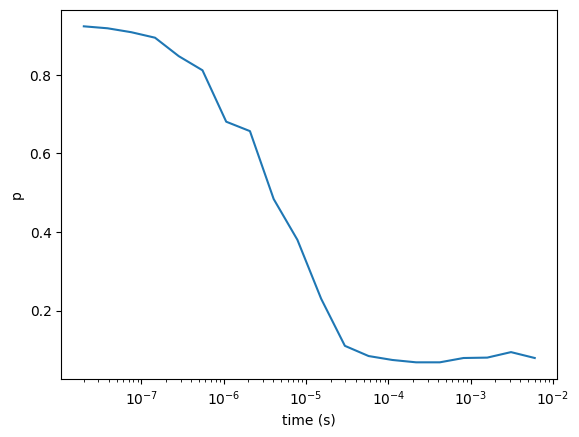

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.semilogx(times, probs, '-')
plt.xlabel('time (s)')
plt.ylabel('p')
plt.show()

### Using a Custom Calibration

All gate and measure applications in a Quil-T program are translated according to either user-supplied or Rigetti calibrations. To easily check which calibration applies to a specific gate, use the `Program.match_calibrations` method.

In [13]:
from math import pi
from pyquil.gates import RX

print(cals.get_calibration(RX(pi, 0)))

DEFCAL RX(pi) 0:
	FENCE 0
	NONBLOCKING PULSE 0 "rf" drag_gaussian(alpha: 0.3183552471062913, anh: -220655329.522463, detuning: -321047.14178613486, duration: 2.4000000000000003e-8, fwhm: 6.000000000000001e-9, phase: 0, scale: 0.625214040700785, t0: 1.2000000000000002e-8)
	FENCE 0


None of the above programs needed us to specify calibrations. By default, the Rigetti native calibrations are used. However, if you specify a calibration in a program, it will take precedence over the native calibrations.

In [14]:
prog = t1_program(1e-6, 0)

# Note: we did NOT specify a calibration for RX(pi) 0 in our previous program
assert prog.match_calibrations(RX(pi, 0)) is None
# The Quil-T translator provided the default: namely, the same calibration we obtained for ourselves
# with `qc.compiler.get_calibration_program()`.

In the example below, we use a custom calibration, we conjugate the usual pulse with a frequency shift. There's no motivation for the particular value used, beyond simply showing what is possible.

In [15]:
prog = Program("""DEFCAL RX(pi/2) 0:
    FENCE 0
    SET-SCALE 0 "rf" 0.353088482172993
    SHIFT-FREQUENCY 0 "rf" 1e6
    NONBLOCKING PULSE 0 "rf" drag_gaussian(duration: 6.000000000000001e-08, fwhm: 1.5000000000000002e-08, t0: 3.0000000000000004e-08, anh: -210000000.0, alpha: 6.389096630631076)
    SHIFT-FREQUENCY 0 "rf" -1e6
    FENCE 0

DECLARE ro BIT
RX(pi/2) 0
MEASURE 0 ro""")
print(prog)

DECLARE ro BIT[1]
DEFCAL RX(pi/2) 0:
	FENCE 0
	SET-SCALE 0 "rf" 0.353088482172993
	SHIFT-FREQUENCY 0 "rf" 1000000
	NONBLOCKING PULSE 0 "rf" drag_gaussian(alpha: 6.389096630631076, anh: -210000000, duration: 6.000000000000001e-8, fwhm: 1.5000000000000002e-8, t0: 3.0000000000000004e-8)
	SHIFT-FREQUENCY 0 "rf" -1000000
	FENCE 0
RX(pi/2) 0
MEASURE 0 ro[0]



In [16]:
print(prog.get_calibration(RX(pi/2, 0)))

DEFCAL RX(pi/2) 0:
	FENCE 0
	SET-SCALE 0 "rf" 0.353088482172993
	SHIFT-FREQUENCY 0 "rf" 1000000
	NONBLOCKING PULSE 0 "rf" drag_gaussian(alpha: 6.389096630631076, anh: -210000000, duration: 6.000000000000001e-8, fwhm: 1.5000000000000002e-8, t0: 3.0000000000000004e-8)
	SHIFT-FREQUENCY 0 "rf" -1000000
	FENCE 0


In [17]:
exe = qc.compiler.native_quil_to_executable(prog)

In [28]:
qc.run(exe).get_register_map()

{'ro': array([[0]])}

Of course, it is not required to use calibrations. One can construct an equivalent program by replacing the `RX` gate with the body of the calibration:

In [19]:
prog = Program("""
DECLARE ro BIT
FENCE 0
SET-SCALE 0 "rf" 0.353088482172993
SHIFT-FREQUENCY 0 "rf" 1e6
NONBLOCKING PULSE 0 "rf" drag_gaussian(duration: 6.000000000000001e-08, fwhm: 1.5000000000000002e-08, t0: 3.0000000000000004e-08, anh: -210000000.0, alpha: 6.389096630631076)
SHIFT-FREQUENCY 0 "rf" -1e6
FENCE 0
MEASURE 0 ro
""".strip())

In [20]:
exe = qc.compiler.native_quil_to_executable(prog)

In [33]:
qc.run(exe).get_register_map()

{'ro': array([[1]])}

#### Parametric Calibrations

Some calibrations (e.g. for `RX`) are defined for specific parameter values. Others may depend on general symbolic values, as with `RZ`.

In [22]:
from pyquil.gates import RZ

print(cals.get_calibration(RZ(pi,0)))

DEFCAL RZ(%theta) 0:
	FENCE 0
	SHIFT-PHASE 0 "rf" -1*%theta
	SHIFT-PHASE 0 1 "xy" -0.5*%theta
	SHIFT-PHASE 0 103 "xy" -0.5*%theta
	FENCE 0


To get more information about how the matching calibration applies to a specific gate, use `Program.match_calibrations`. The result is a `CalibrationMatch` object which indicates not just the calibration, but the value for parameters.

In [23]:
match = cals.match_calibrations(RZ(pi,0))
print(match.cal)
print(match.settings)

DEFCAL RZ(%theta) 0:
	FENCE 0
	SHIFT-PHASE 0 "rf" -1*%theta
	SHIFT-PHASE 0 1 "xy" -0.5*%theta
	SHIFT-PHASE 0 103 "xy" -0.5*%theta
	FENCE 0
{Parameter('theta'): (3.141592653589793+0j)}


You may conveniently recover the body of the calibration, with the matched parameters substituted, using `Program.calibrate`.

In [24]:
instrs = cals.calibrate(RZ(pi,0))
for instr in instrs:
    print(instr)

FENCE 0
SHIFT-PHASE 0 "rf" -1*3.141592653589793
SHIFT-PHASE 0 1 "xy" -0.5*3.141592653589793
SHIFT-PHASE 0 103 "xy" -0.5*3.141592653589793
FENCE 0


### Non-Native Gates
As mentioned above, the `qc.compiler.native_quil_to_executable` call will provide calibrations for Rigetti native gates, if they are not provided by a user. However, a program with non-native gates and no corresponding user-provided calibrations will result in a compilation failure.

In [25]:
prog = Program("DECLARE ro BIT\n"
               "H 0\n"
               "CNOT 0 1\n"
               "MEASURE 0 ro")

try:
    qc.compiler.native_quil_to_executable(prog)
except Exception as e:
    print("Fails on non-native operations {H, CNOT} as expected.")

Fails on non-native operations {H, CNOT} as expected.
